# Extracting relevant information to construct seed values for linear mixing endmember spectra

In [379]:
import import_ipynb
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy.stats import gaussian_kde


import torch
import torch .nn as nn
import torch .optim as optim

import json

import gc

plt.rcParams['text.usetex'] = True

In [27]:
data = np.loadtxt("../data/RaCA-spectra-first100.csv",
                 delimiter=",", dtype=str)

In [28]:
data[0,2152:]
sample_top   = data[1:,2153].astype('float32')
sample_bot   = data[1:,2154].astype('float32')
sample_txtr  = data[1:,2156]
sample_bd    = data[1:,2158].astype('float32')
sample_bdsd  = data[1:,2159].astype('float32')
sample_soc   = data[1:,2162].astype('float32')
sample_socsd = data[1:,2163].astype('float32')

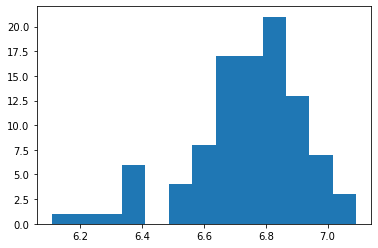

In [90]:
dataI = data[1:,1:2152].astype('float32')
plt.hist(np.log(np.sum(dataI,axis=1)),bins='auto');
XF = np.array([x for x in range(350,2501)]);

In [394]:
sample_socsd/sample_soc

array([0.621686  , 0.621686  , 0.621686  , 0.62168604, 0.621686  ,
       0.621686  , 0.621686  , 0.621686  , 0.621686  , 0.621686  ,
       0.62168604, 0.621686  , 0.62168604, 0.621686  , 0.621686  ,
       0.621686  , 0.621686  , 0.621686  , 0.621686  , 0.621686  ,
       0.621686  , 0.621686  , 0.621686  , 0.621686  , 0.62168604,
       0.621686  , 0.621686  , 0.621686  , 0.62168604, 0.621686  ,
       0.621686  , 0.62168604, 0.621686  , 0.621686  , 0.621686  ,
       0.621686  , 0.621686  , 0.62168604, 0.621686  , 0.62168604,
       0.621686  , 0.62168604, 0.621686  , 0.62168604, 0.621686  ,
       0.621686  , 0.621686  , 0.621686  , 0.62168604, 0.621686  ,
       0.621686  , 0.62168604, 0.621686  , 0.62168604, 0.621686  ,
       0.621686  , 0.62168604, 0.621686  , 0.621686  , 0.621686  ,
       0.621686  , 0.621686  , 0.621686  , 0.621686  , 0.621686  ,
       0.621686  , 0.62168604, 0.621686  , 0.621686  , 0.621686  ,
       0.621686  , 0.621686  , 0.621686  , 0.621686  , 0.62168

### Summarial Statistics: Means, variances, difference distributions

(0.0, 1.0)

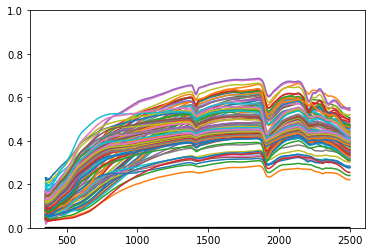

In [91]:
plt.plot(XF,dataI.T);
plt.plot(XF,np.max(I,axis=0),'black');
plt.ylim([0,1.0])

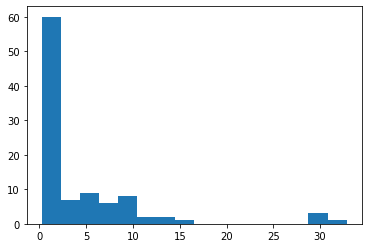

In [6]:
plt.hist(sample_soc,bins='auto');

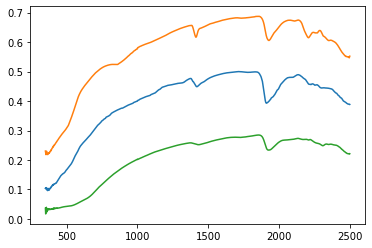

In [37]:
plt.plot(XF,np.median(I.T,axis=1))
plt.plot(XF,np.max(I.T,axis=1))
plt.plot(XF,np.min(I.T,axis=1))

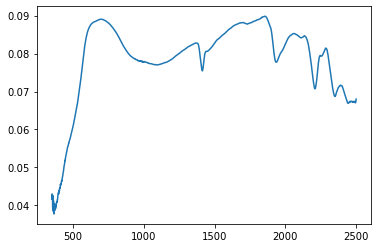

In [29]:
plt.plot(XF,np.sqrt(np.var(I.T,axis=1)))


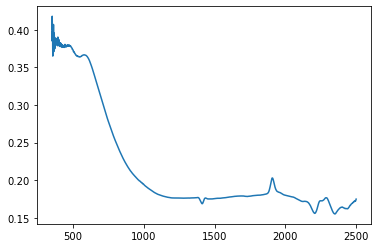

In [28]:
plt.plot(XF,np.sqrt(np.var(I.T,axis=1))/np.mean(I.T,axis=1))

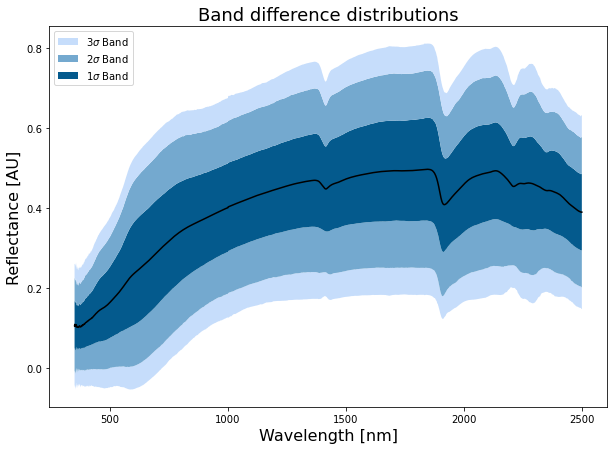

In [ ]:
def get_quantile_diff_dist_fast(tI) :
    return np.abs(I - I[:,np.newaxis]).reshape([I.shape[0] ** 2,I.shape[1]])

def get_quantile_diff_dist(tI, q) :
    NN = tI.shape[0]
    diffs = np.zeros([int(NN*(NN-1)/2),tI.shape[1]])
    
    ind=0
    for i in range(NN) :
        for j in range(i) :
            diffs[ind,:] = np.abs(tI[i,:] - tI[j,:])
            ind+=1
            
    print(diffs.shape)
    
    return np.quantile(diffs, q, axis=0)

diff_dist = get_quantile_diff_dist_fast(I);
vlamb68 = np.quantile(diff_dist, 0.68, axis=0) # 1 sigma
vlamb95 = np.quantile(diff_dist, 0.95, axis=0) # 2 sigma
vlamb99 = np.quantile(diff_dist, 0.99, axis=0) # 3 sigma

sandplot_y = [np.mean(I,axis=0) - vlamb99, vlamb99 - vlamb95, vlamb95 - vlamb68, 2.0*vlamb68, vlamb95 - vlamb68, vlamb99 - vlamb95]

COLORS = ["#FFFFFF", "#C6DDFB", "#74A9CF", "#045A8D", "#74A9CF", "#C6DDFB"]
fig, ax = plt.subplots(figsize=(10, 7))
ax.stackplot(XF, sandplot_y, colors=COLORS, baseline="zero", labels=[None,'3$\sigma$ Band','2$\sigma$ Band','1$\sigma$ Band']);
plt.plot(XF, np.mean(I, axis=0), 'black')

plt.ylabel('Reflectance',fontsize=16)
plt.xlabel('Wavelength [nm]',fontsize=16)

ax.set_title('Band difference distributions', fontsize=18)
plt.legend(loc='upper left')
plt.show()

### Correlations between soil variables and spectral lines

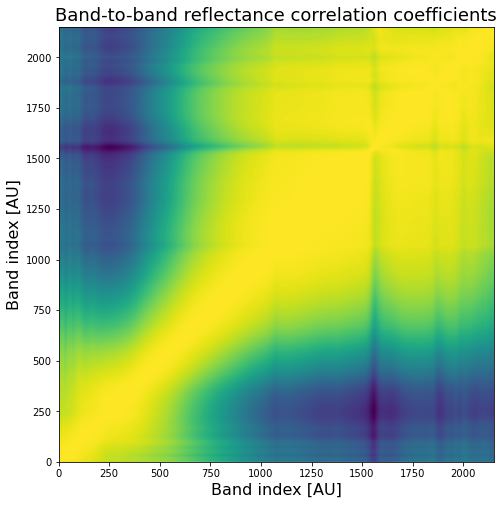

In [31]:
fig, ax = plt.subplots(figsize=(8, 8))
plt.imshow(np.corrcoef(I, I, rowvar = False),interpolation='none')

plt.ylabel('Band index [AU]',fontsize=16)
plt.xlabel('Band index [AU]',fontsize=16)

ax.set_title('Band-to-band reflectance correlation coefficients', fontsize=18)

plt.xlim([0,2150])
plt.ylim([0,2150])

plt.show()

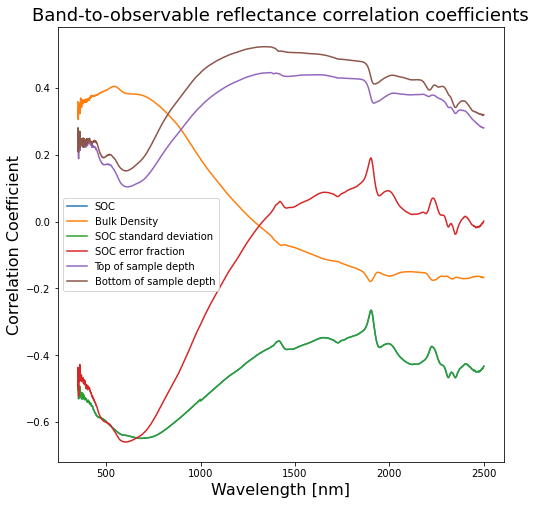

In [33]:
figbb, axbb = plt.subplots(figsize=(8, 8))
plt.plot(XF,np.corrcoef(I, sample_soc, rowvar = False)[:-1,-1],   label='SOC')
plt.plot(XF,np.corrcoef(I, sample_bd, rowvar = False)[:-1,-1],    label='Bulk Density')
plt.plot(XF,np.corrcoef(I, sample_socsd, rowvar = False)[:-1,-1], label='SOC standard deviation')
plt.plot(XF,np.corrcoef(I, sample_socsd/(sample_soc+0.0000001), rowvar = False)[:-1,-1], label='SOC error fraction')
plt.plot(XF,np.corrcoef(I, sample_top, rowvar = False)[:-1,-1],   label='Top of sample depth')
plt.plot(XF,np.corrcoef(I, sample_bot, rowvar = False)[:-1,-1],   label='Bottom of sample depth')


plt.ylabel('Correlation Coefficient',fontsize=16)
plt.xlabel('Wavelength [nm]',fontsize=16)

axbb.set_title('Band-to-observable reflectance correlation coefficients', fontsize=18)
axbb.legend()

plt.show()

### Correlations between soil variables independently of spectral lines

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
plt.imshow(np.corrcoef(I, sample_soc, rowvar = False),interpolation='none')

plt.ylabel('Band index [AU]',fontsize=16)
plt.xlabel('Band index [AU]',fontsize=16)

ax.set_title('Band-to-band reflectance correlation coefficients', fontsize=18)

plt.xlim([0,2150])
plt.ylim([0,2150])

plt.show()

### Principal component analysis / k-means clustering breaking down classes of spectra

#### Correlations between soil variables for each spectral class

#### Correlations between soil variables for each spectral class

#### Identification of spectral troughs for each spectral class

# Full fit to pseudodata

In [56]:
KEndmembers = 87
NPoints = 999
MSpectra = 2151

### Pull F's and m_{SOC}'s, generate seed m's and alphas

In [57]:
# load JSON file with pure spectra
endMemMap = json.load(open('../data/endmember spectral data.json'))

# get reflectance spectra (y axis) and wavelength grid (x axis)
endMemList = [x for x in endMemMap.keys()];
endMemList.remove("General")
XF = endMemMap["General"]["Postprocessed Wavelength Axis [nm]"]
F = [endMemMap[x]["Postprocessed Reflectance"] for x in endMemList]

# get density, radius info and merge into relevant arrays
rhos = [endMemMap[x]["Density (Mg/m^3)"] for x in endMemList]
rads = [endMemMap[x]["Effective Radius (nm)"] for x in endMemList]

/var/folders/6w/zm__23zx1fn9ljlttn9tntb40000gn/T/ipykernel_9439/4241453255.py:28: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  axarr[0].set_xlim([0,35])
/var/folders/6w/zm__23zx1fn9ljlttn9tntb40000gn/T/ipykernel_9439/4241453255.py:39: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  axarr[1].set_xlim([0,35])


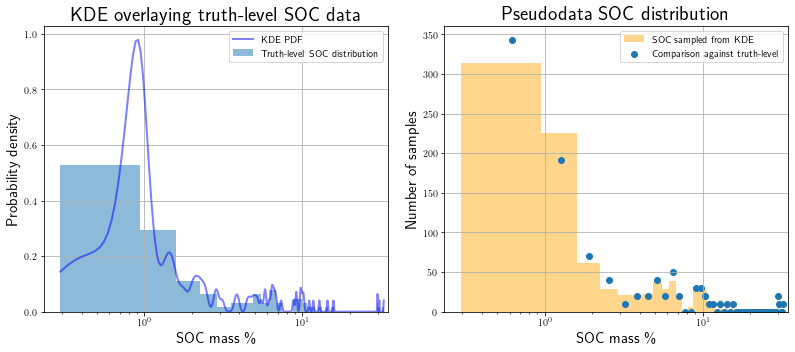

In [308]:
# pull m_SOC from a KDE of the RaCA histogram of SOC values
def kde(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scipy"""
    kde = gaussian_kde(x, bw_method=bandwidth / x.std(ddof=1), **kwargs)
    return kde.evaluate(x_grid)

def generate_rand_from_pdf(pdf, x_grid):
    cdf = np.cumsum(pdf)
    cdf = cdf / cdf[-1]
    values = np.random.rand(NPoints)
    value_bins = np.searchsorted(cdf, values)
    random_from_cdf = x_grid[value_bins]
    return random_from_cdf

hist, bins = np.histogram(sample_soc, bins=50)
x_grid = np.linspace(min(sample_soc), max(sample_soc), 1000)
kdepdf = kde(sample_soc, x_grid, bandwidth=0.1)
msoc = generate_rand_from_pdf(kdepdf, x_grid)

_, axarr = plt.subplots(1,2,figsize=(10,5))

axarr[0].hist(sample_soc, bins=50, density=True, alpha=0.5, label='Truth-level SOC distribution')
axarr[0].plot(x_grid, kdepdf, color='b', alpha=0.5, lw=2, label='KDE PDF')
axarr[0].set_xlabel("SOC mass \%",fontsize=15)
axarr[0].set_ylabel("Probability density",fontsize=15)
axarr[0].set_title("KDE overlaying truth-level SOC data",fontsize=20)
axarr[0].set_xscale('log')
axarr[0].set_xlim([0,35])
axarr[0].legend()
axarr[0].grid()

axarr[1].scatter((bins[1:] + bins[:-1])/2,hist * NPoints/np.sum(hist), label='Comparison against truth-level',zorder=1)
axarr[1].hist(msoc, 50, alpha=0.45, color='orange', label='SOC sampled from KDE',zorder=0)
axarr[1].legend()
axarr[1].set_xlabel("SOC mass \%",fontsize=15)
axarr[1].set_ylabel("Number of samples",fontsize=15)
axarr[1].set_title("Pseudodata SOC distribution",fontsize=20)
axarr[1].set_xscale('log')
axarr[1].set_xlim([0,35])
axarr[1].grid()
plt.tight_layout()
plt.subplots_adjust(right=1.1)
plt.show()

del hist, bins, x_grid, kdepdf, axarr

In [208]:
def gaus(mu, sigma, N=1) :
    return np.random.randn(N) * sigma + mu;

In [59]:
# generate seed alphas from seed M's, specified below from initial literature

seedMsDict = {}

# feldspar 33.6%
# amphiboles & pyroxenes 5.6%
# micas 1.3%
# titanium minerals 0.5%
# apatite 0.2%
# clays 10.5%
# iron oxides 2.5%
# carbonates 5.6%
# other minerals 4.5%
# silica? 27.0%
# total: 91.3%, assume accurate for now

seedMsDict["silica"] = 0.27

# feldspars
seedMsDict["orthoclase"] = 0.336/3.
seedMsDict["albite"]     = 0.336/3.
seedMsDict["anorthite"]  = 0.336/3.

# amphiboles, pyroxenes
seedMsDict["hornblende"] = 0.0187
seedMsDict["tremolite"] = 0.0187
seedMsDict["cummingtonite"] = 0.0187

# micas
seedMsDict["biotite"] = 0.00325
seedMsDict["muscovite"] = 0.00325
seedMsDict["phlogopite"] = 0.00325
seedMsDict["vermiculite"] = 0.00325

# carbonates
seedMsDict["hydromagnesite"] = 0.008
seedMsDict["magnesite"] = 0.008
seedMsDict["dolomite"] = 0.008
seedMsDict["siderite"] = 0.008
seedMsDict["aragonite"] = 0.008
seedMsDict["magnesite"] = 0.008
seedMsDict["trona"] = 0.008

# small contributors
seedMsDict["apatite"]  = 0.002
seedMsDict["zircon"] = 0.005

# total pre-defined: 73.8%

# collect constant seeds from the definitions above
seedMs = [seedMsDict[x] if x in seedMsDict else 0.0 for x in endMemList]
seedMs = seedMs + [0.0]

# make seedMs an N x K matrix
seedMs = np.ones([NPoints,KEndmembers]) * seedMs
seedMs[:,KEndmembers-1] = msoc
seedMrem = 1.0 - np.sum(seedMs,axis=1)

# get seeds that haven't been filled in yet, excluding SOC
# if remaining mass fraction is < 0, exclude from further partitioning
seedMZeros = ((seedMs == 0.0).astype('float32').T * (seedMrem >= 0.0).astype('float32')).T
seedMZeros[:,KEndmembers-1] = 0.0

# sample random remaining seeds and renormalize to the appropriate remainder
seedMZeros = seedMZeros * np.random.random([NPoints,KEndmembers])
seedMZeros = (seedMZeros.T / (np.sum(seedMZeros,axis=1)+0.0000001)).T
seedMZeros = (seedMZeros.T * seedMrem).T

# add remaining seeds into seedMs
seedMs = seedMs + seedMZeros 
seedMs = (seedMs.T / np.sum(seedMs, axis=1)).T

del seedMZeros, seedMrem

### Generate SOC seed F

In [278]:
def fakeTrough(x,mu,sigma) :
    return 0.1*np.exp(-(x-mu)**2/2.0/sigma)

organicTroughs = [1650,1100,825,2060,1500,1000,751,1706,1754,1138,1170,853,877,1930,1449,2033,1524,2275,1706,1961,2137,2381,1400,1900,1791,2388]

tFsoc = np.sum(dataI.T * sample_soc,axis=1)/np.sum(sample_soc)
trueFsoc = tFsoc - 0.125*np.sum(fakeTrough((np.zeros([1,MSpectra])+XF).T,np.array(organicTroughs),3000).T,axis=0)
seedFsoc = tFsoc - 0.125*gaus(1.0,0.5)*np.sum(fakeTrough((np.zeros([1,MSpectra])+XF).T,np.array(organicTroughs),3000*gaus(1.0,0.25,len(organicTroughs))).T,axis=0)

F = [endMemMap[x]["Postprocessed Reflectance"] for x in endMemList]
F = np.array(F + [trueFsoc])

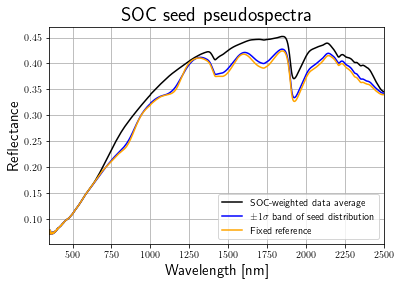

In [372]:
plt.plot(XF,tFsoc.T, 'black',label="SOC-weighted data average")
plt.plot(XF,trueFsoc.T, 'blue', label="$\pm1\sigma$ band of seed distribution")
plt.plot(XF,seedFsoc.T, 'orange', label="Fixed reference")
plt.legend()

plt.xlim([350,2500])

plt.xlabel("Wavelength [nm]",fontsize=15)
plt.ylabel("Reflectance",fontsize=15)
plt.title("SOC seed pseudospectra",fontsize=20)
plt.grid()

#plt.ylim([0,1.1])

### Generate reflectance pseudodata from mixing model

In [200]:
# make trueMs an N x K matrix
trueMs = np.zeros([NPoints,KEndmembers])
trueMs[:,KEndmembers-1] = msoc
trueMrem = 1.0 - np.sum(trueMs,axis=1)

# get seeds that haven't been filled in yet, excluding SOC
# if remaining mass fraction is < 0, exclude from further partitioning
trueMZeros = ((trueMs == 0.0).astype('float32').T * (trueMrem >= 0.0).astype('float32')).T
trueMZeros[:,KEndmembers-1] = 0.0

# sample random remaining seeds and renormalize to the appropriate remainder
trueMZeros = trueMZeros * np.random.random([NPoints,KEndmembers])
trueMZeros = (trueMZeros.T / (np.sum(trueMZeros,axis=1)+0.0000001)).T
trueMZeros = (trueMZeros.T * trueMrem).T

# add remaining seeds into seedMs
trueMs = trueMs + trueMZeros 
trueMs = (trueMs.T / np.sum(trueMs, axis=1)).T

del trueMZeros, trueMrem

In [243]:
def A(ms,rhorads) :
    tA = ms / rhorads
    return (tA.T / np.sum(tA,axis=1)).T

def torchA(ms,rhorads) :
    tA = ms / rhorads
    return tA / torch.sum(tA,axis=1)

rhorads = np.array(rhos)*np.array(rads)
trueSOCrr = np.mean(rhorads)
seedSOCrr = np.mean(rhorads)*gaus(1.0,0.2)
trueAs = A(trueMs,np.append(rhorads,trueSOCrr))
seedAs = A(seedMs,np.append(rhorads,seedSOCrr))

In [202]:
# generate Is from Fs and As
trueI = np.dot(trueAs,F)

# add random noise to I
# noiseV = 0.0
# noiseB = 0.0
# I = I + noiseV*np.random.randn(NPoints, MSpectra) + noiseB

# Gaussian smearing?

In [203]:
# get the max I at each peak, for stabilizing the optimization
maxI = np.max(I,axis=0)

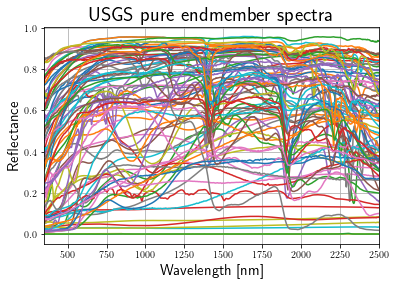

In [346]:
plt.plot(XF,F.T);
plt.xlabel(r'Wavelength [nm]',fontsize=15)
plt.ylabel(r'Reflectance',fontsize=15)
plt.title(r'USGS pure endmember spectra',fontsize=20)
plt.xlim([350,2500])
plt.grid()

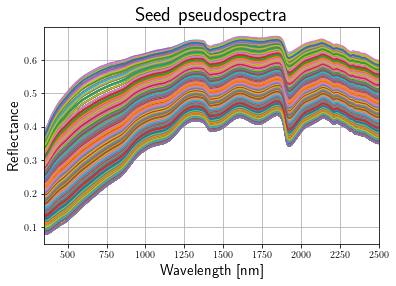

In [347]:
plt.plot(XF,np.dot(seedAs,F).T);
plt.xlabel(r'Wavelength [nm]',fontsize=15)
plt.ylabel(r'Reflectance',fontsize=15)
plt.title(r'Seed pseudospectra',fontsize=20)
plt.xlim([350,2500])
plt.grid()
#plt.plot(XF,maxI.T,'b');

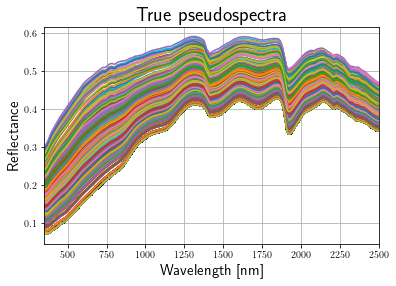

In [348]:
plt.plot(XF,np.dot(trueAs,F).T);
plt.xlabel(r'Wavelength [nm]',fontsize=15)
plt.ylabel(r'Reflectance',fontsize=15)
plt.title(r'True pseudospectra',fontsize=20)
plt.xlim([350,2500])
plt.grid()
#plt.plot(XF,maxI.T,'b');

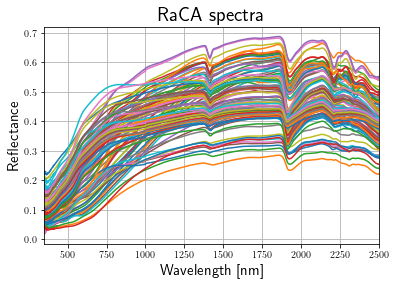

In [342]:
plt.plot(XF,dataI.T);
plt.xlabel(r'Wavelength [nm]',fontsize=15)
plt.ylabel(r'Reflectance',fontsize=15)
plt.title(r'RaCA spectra',fontsize=20)
plt.xlim([350,2500])
plt.grid()

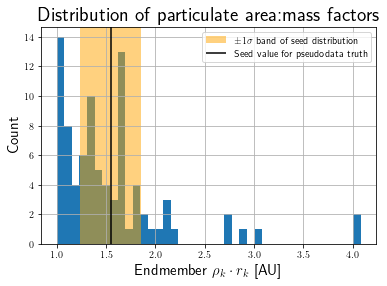

In [392]:
f, ax = plt.subplots()
th = plt.hist(rhorads,bins=40);
plt.xlabel(r'Endmember $\rho_k \cdot r_k$ [AU]',fontsize=15)
plt.ylabel(r'Count',fontsize=15)
plt.title(r'Distribution of particulate area:mass factors',fontsize=20)
plt.grid()

plt.vlines(trueSOCrr,ymin=0,ymax=np.max(th[0])*1.05,color='black',label=r'Seed value for pseudodata truth');
#plt.vlines(seedSOCrr,ymin=0,ymax=np.max(th[0])*1.05,color='orange');
ax.add_patch(Rectangle((trueSOCrr*0.8,0),trueSOCrr*0.4,np.max(th[0])*1.05,facecolor="orange",alpha=0.5,label=r'$\pm1\sigma$ band of seed distribution'));
plt.ylim([0,np.max(th[0])*1.05])
plt.legend()
plt.show()

In [180]:
# seed data: A[1:,:] and initial F's
tF       = torch.tensor(F[:-1,:].tolist())
tFsoc    = torch.tensor(Fsoc.tolist())
tseedMs  = torch.tensor(seedMs[:,:-1].tolist())
tmsoc    = torch.tensor(msoc.tolist())
trhorads = torch.tensor(rhorads[:-1].tolist())
trrsoc   = torch.tensor(rhorads[-1])

# empirical data: (SOC values, reflectances, and max normalized reflectance)
ys = (tmsoc,torch.tensor(I.tolist()),torch.tensor(maxI.tolist()))

### Run fit

In [198]:
class LinearMixingModel(nn.Module):
    def __init__(self, seedFs, seedFsoc, seedMs, rhorad, seedrrsoc):
        super().__init__()
        # fixed quantities
        self.rhorad = rhorad
        self.fs     = seedFs
        
        # model parameters
        self.fsoc   = nn.Parameter(seedFsoc)
        self.rrsoc  = seedrrsoc
        self.ms     = nn.Parameter(seedMs)
        
        # model output
        self.Ihat   = 0;
        
        # variables for tracking optimization
        self.lsq = [];
        self.loss = [];
        self.bdsALoss = [];
        self.bdsFLoss = [];
        self.omrsLoss = [];
        self.diffloss1 = [];
        self.difflossfull = [];
        
    def forward(self, y):
        msocs,Is,Imax = y
        rrFull    = torch.cat((self.rhorad,self.rrsoc.unsqueeze(0)))
        mFull     = torch.cat((self.ms,msocs.unsqueeze(1)),dim=1)
        mFull     = (mFull.t() / torch.sum(mFull,axis=1)).t()
        fFull     = torch.cat((self.fs,self.fsoc.unsqueeze(0)),dim=0)
        self.Ihat = torch.matmul(torchA(mFull,rrFull).float(),fFull.float())
                
        # Add in a fake Lagrange multiplier to discourage abundances < 0.01 or > 0.99
        oobsA = torch.sum((mFull < 0.001).float() * (mFull - 0.001)**2) 
        oobsA = oobsA + torch.sum((mFull > 0.999).float() * (mFull + 0.001 - 1.0) **2)

        # Add in a fake Lagrange multiplier to discourage Fsoc < 0
        oobsF = 1.0 * torch.sum((self.fsoc < 0.0).float() * (self.fsoc ** 2)) 
        oobsF = oobsF + 1.0 * torch.sum((self.fsoc > 1.0).float() * (1.0 - self.fsoc) **2)

        # Add in a fake Lagrange multiplier to discourage reflectances in F's that are above empirical max
        omrs = 0.0 #torch.sum((self.fsoc > Imax).float() * (self.fsoc - Imax))
        
        # Add in 1st derivative loss to smooth the curves
        diffloss = torch.sum(torch.diff(self.fsoc) ** 2)
        self.diffloss1 += [diffloss.detach().item()];
        
        diffloss += torch.sum(torch.diff(torch.diff(self.fsoc)) ** 2)
        
        lsq = torch.sum((Is - self.Ihat) ** 2)
        loss = lsq * (1 + 10000.0*omrs + 100.0* diffloss + 100.0*oobsA + 1000.0*oobsF)
        
        self.lsq += [lsq.detach().item()]
        self.loss += [loss.detach().item()];
        self.bdsALoss += [oobsA.detach().item()];
        self.bdsFLoss += [oobsF.detach().item()];
        #self.omrsLoss += [omrs.detach().item()];
        self.difflossfull += [diffloss.detach().item()];
        
        # Compute the loss function, which is the mean-squared error between data and prediction,
        # with a multiplicative factor for our fake Lagrange multipliers
        return loss

In [199]:
model = LinearMixingModel(tF,tFsoc,tseedMs,trhorads,trrsoc)
optimizer = optim.Adam(model.parameters(), lr = 0.0001)

for epoch in range(20000) :
    loss = model(ys)
    e = torch.mean(loss)
    e.backward()
    optimizer.step()
    optimizer.zero_grad()

print("Epoch ",epoch,": ", loss.detach().item())

Epoch  19999 :  3.3486779216218565e-07


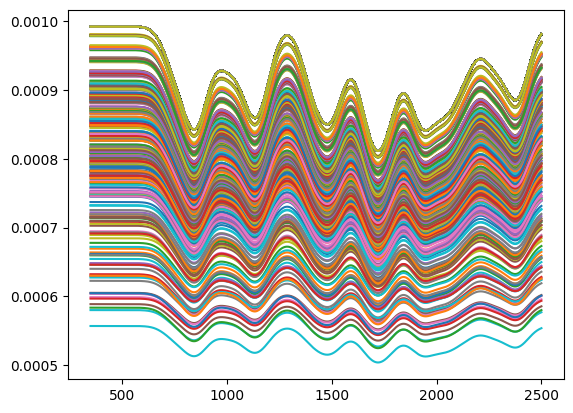

In [200]:
plt.plot(XF,model.Ihat.detach().numpy().T);

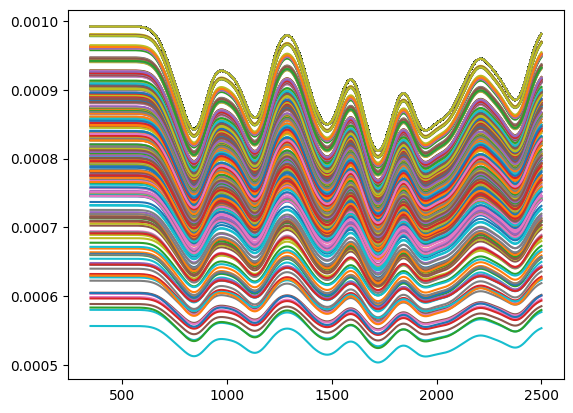

In [201]:
plt.plot(XF,I.T);

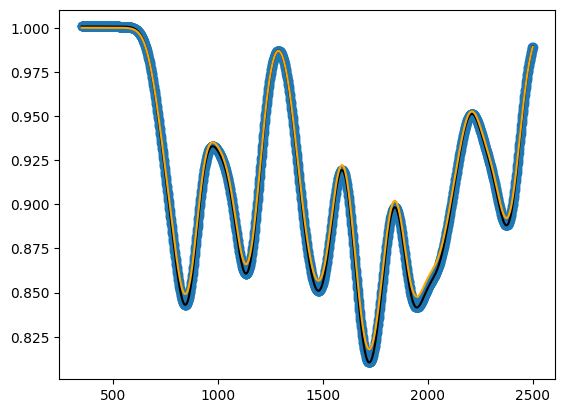

In [202]:
plt.plot(XF,model.fsoc.detach().numpy(),'black')
plt.scatter(XF,tFsoc.detach().numpy())
plt.plot(XF,Fsoc,'orange')

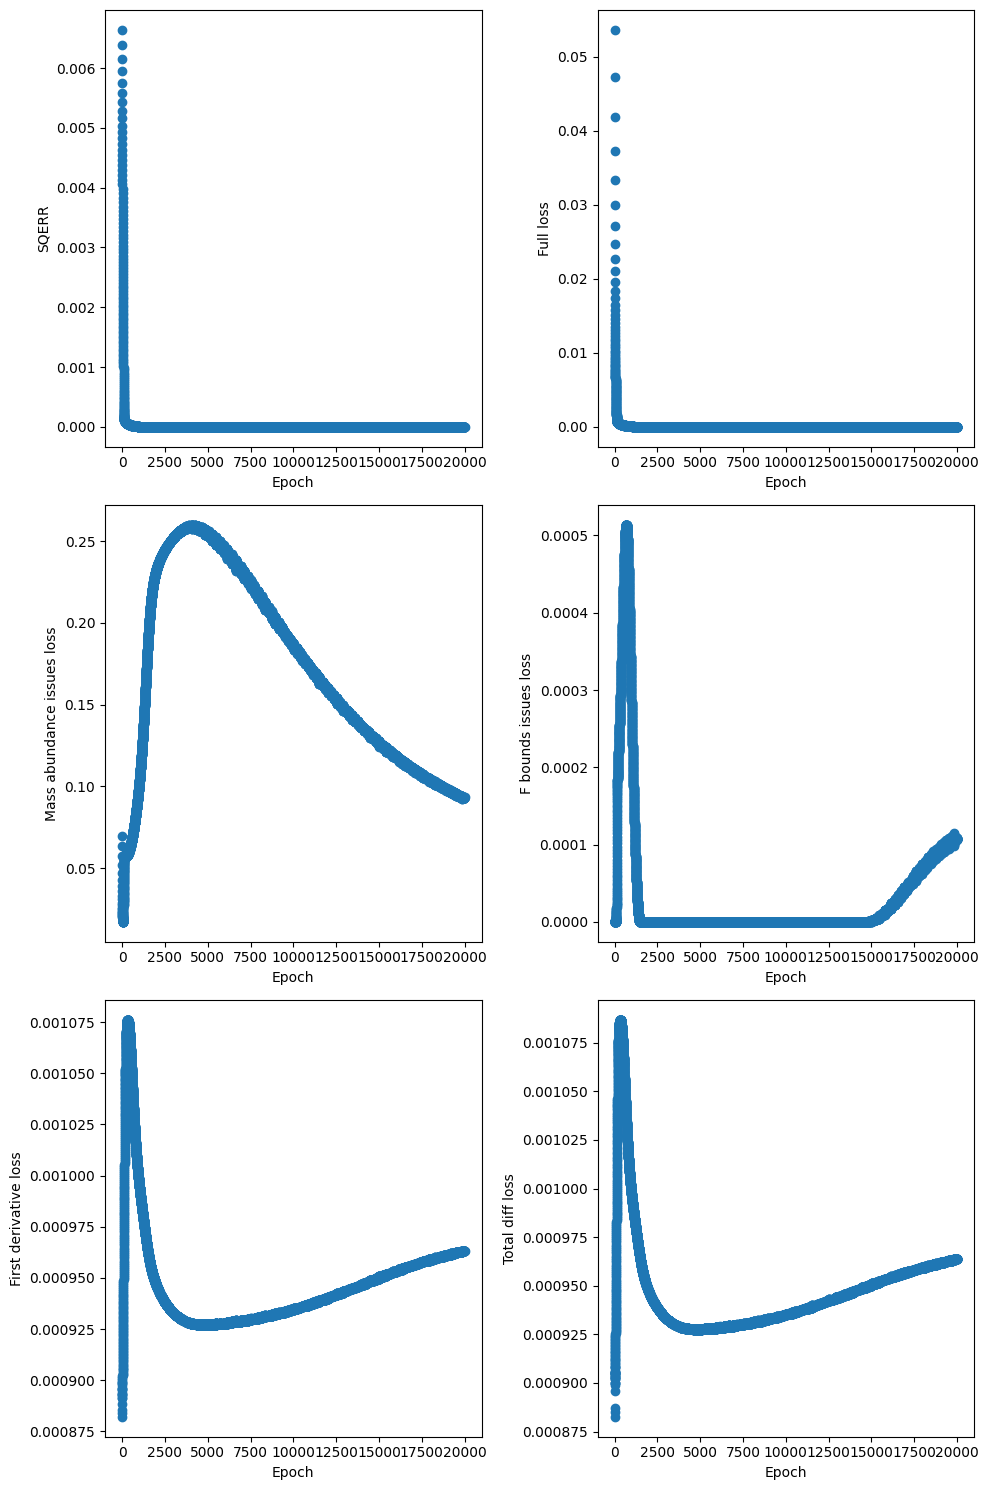

In [203]:
_, axarr = plt.subplots(3,2,figsize=(10,15))

axarr[0,0].scatter([i for i in range(len(model.lsq))],model.lsq)
axarr[0,0].set_xlabel("Epoch")
axarr[0,0].set_ylabel("SQERR")

axarr[0,1].scatter([i for i in range(len(model.loss))],model.loss)
axarr[0,1].set_xlabel("Epoch")
axarr[0,1].set_ylabel("Full loss")

axarr[1,0].scatter([i for i in range(len(model.bdsALoss))],model.bdsALoss)
axarr[1,0].set_xlabel("Epoch")
axarr[1,0].set_ylabel("Mass abundance issues loss")

axarr[1,1].scatter([i for i in range(len(model.bdsFLoss))],model.bdsFLoss)
axarr[1,1].set_xlabel("Epoch")
axarr[1,1].set_ylabel("F bounds issues loss")

axarr[2,0].scatter([i for i in range(len(model.diffloss1))],model.diffloss1)
axarr[2,0].set_xlabel("Epoch")
axarr[2,0].set_ylabel("First derivative loss")

axarr[2,1].scatter([i for i in range(len(model.difflossfull))],model.difflossfull)
axarr[2,1].set_xlabel("Epoch")
axarr[2,1].set_ylabel("Total diff loss")

plt.tight_layout()
plt.show()